## Experiment:  AugmentedMNIST - Learn Variance

Training params:
    - Network: VAEVariance
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 28 x 28
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.mnist import MNISTDataModule
from src.data.mnist import ConstantDataset
from src.data.fashionmnist import FashionMNISTDataModule
from src.data.bg_aug_mnist import BgAugMNISTDataModule
import torch
from src.models.vae.basic_vae_variance import BasicVAEVariance
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
mnist = MNISTDataModule()
mnist_aug_bg = MNISTDataModule()
fashion = FashionMNISTDataModule()
constant_black = ConstantDataset()
aug_mnist = BgAugMNISTDataModule(single_image=True)

mnist.prepare_data()
mnist.setup()

mnist_aug_bg.prepare_data()
mnist_aug_bg.setup()

fashion.prepare_data()
fashion.setup()

aug_mnist.prepare_data()
aug_mnist.setup()

experiment_name = 'BasicVAEVariance_AugMNIST_Full_Image'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=10,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=40, gpus=1, logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)


EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
model = BasicVAEVariance()
trainer.fit(model, aug_mnist)

KeyboardInterrupt: 

In [5]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [6]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_VAE_full_img = BasicVAEVariance().load_from_checkpoint(checkpoint_path=model_path).cuda()
eval_VAE_full_img.eval()
mnist_test = mnist.test_dataloader()
fashion_test = fashion.test_dataloader()

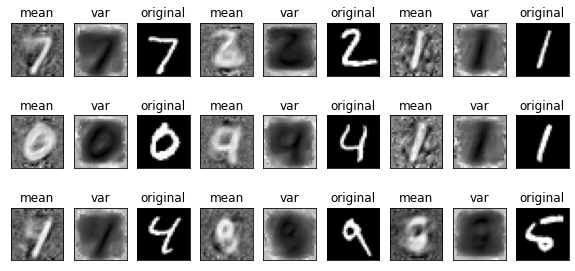

In [9]:
from src.utils.vae import generate_images
# no changes applied to variance during training
# images are reconstructed by sampling from the normal distribution with learned mean and std dev values. 
generate_images(eval_VAE_full_img, mnist_test)

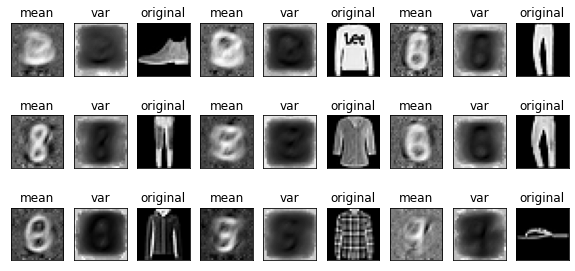

In [10]:
from src.utils.vae import generate_images
# no changes applied to variance during training
# images are reconstructed by sampling from the normal distribution with learned mean and std dev values. 
generate_images(eval_VAE_full_img, fashion_test)

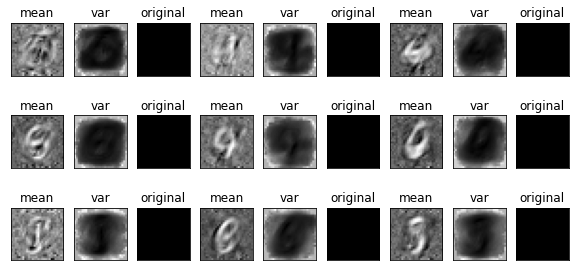

In [14]:
from src.utils.vae import generate_images
# latent dim = 80
generate_images(eval_VAE_full_img, constant_black)

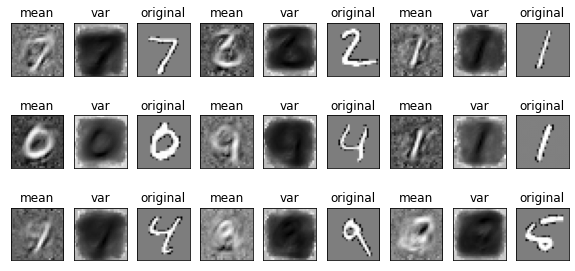

In [16]:
from src.utils.vae import generate_images
# latent dim = 40
generate_images(eval_VAE_full_img, mnist_test, random_bg=True)

In [10]:
from src.utils.vae import plot_loss_histogram
idd_losses, ood_losses = plot_loss_histogram(eval_VAE_full_img, mnist_test, fashion_test)
print(len(idd_losses))

10000


 ROC AUC=0.09556


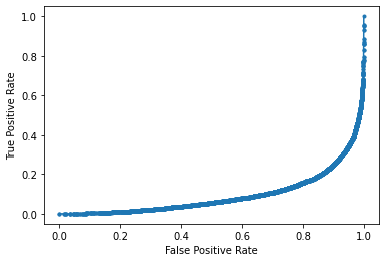

In [11]:
from src.utils.ood_test import plot_roc_auc
targets = np.concatenate(((np.zeros(len(idd_losses))), np.ones(len(ood_losses))))
results = np.concatenate((idd_losses, ood_losses))
plot_roc_auc(targets, results)